# Speaker recognizer

Table of contents:
1. Process audio data
    1. Get speakers count
    2. Get audio files 
    3. Visualize data
    4. Slice audio files into 2 sec pieces and parametrize it
    5. Save parametrized data to csv files
2. LSTM Model
    1. Get users
    2. Define DataGenerator class
    3. Create model
    4. Get train and validation data sets
    5. Train model
    6. Vizualize model
3. Create biometric model
    1. Calculate embedings
    2. Calculate enrollment data and genuine tests
    3. Calculate impostor tests
    4. Results

## Process audio data

### Get speakers count

In [255]:
from glob import glob

In [256]:
user_count = len(glob('./LibriSpeech/train-other-500/*/', recursive=False))
print(f'speaker count: {user_count:,}')

speaker count: 1,166


### Get audio files

In [257]:
files = glob(f'./LibriSpeech/train-other-500/**/*.flac', recursive=True)
files_count = len(files)
print(f'files count: {files_count:,}')

files count: 148,687


### Visualize data

In [258]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

[Text(0.5, 1.0, 'Delta2')]

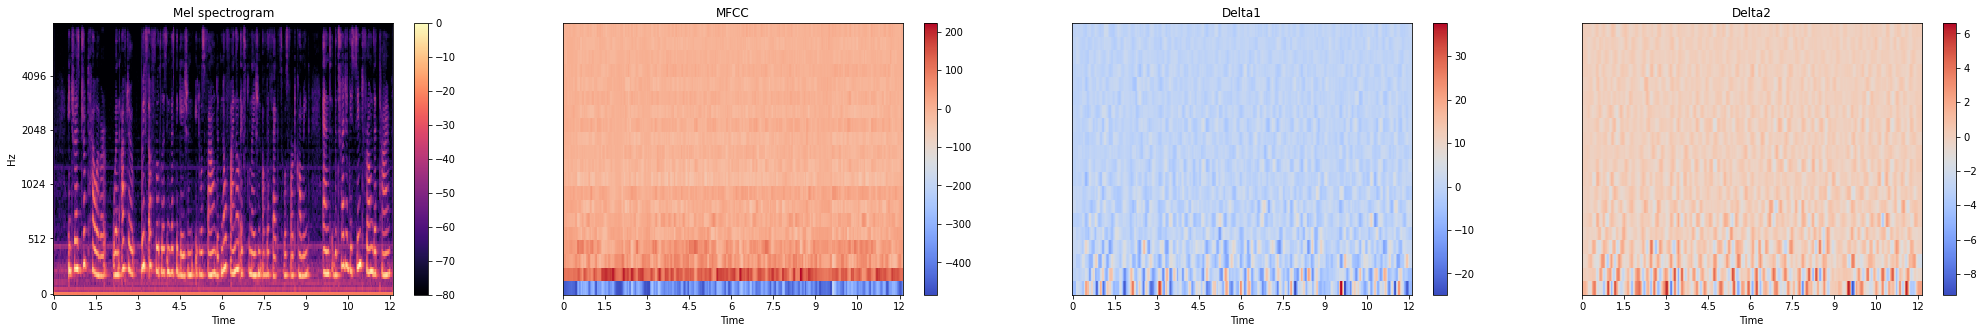

In [371]:
y, sr = librosa.load(files[0])
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
delta1 = librosa.feature.delta(mfccs)
delta2 = librosa.feature.delta(delta1)

fig, ax = plt.subplots(ncols=4, nrows=1, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(35)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
img1 = librosa.display.specshow(delta1, x_axis='time', ax=ax[2])
img2 = librosa.display.specshow(delta2, x_axis='time', ax=ax[3])
fig.colorbar(img, ax=[ax[1]])
fig.colorbar(img1, ax=[ax[2]])
fig.colorbar(img2, ax=[ax[3]])
ax[1].set(title='MFCC')
ax[2].set(title='Delta1')
ax[3].set(title='Delta2')

### Slice audio files into 2 sec pieces and parametrize it

In [260]:
import librosa

In [261]:
def parametrize_audio(file):
    lst = []

    data, sr = librosa.load(file, sr=16000)
    dur = librosa.get_duration(y=data)
    one_sec = int(data.shape[0] / dur)
    
    for i in range(0, int(dur) // 2 * 2, 2):
        two_sec_slice = data[i * one_sec:(i + 2) * one_sec]

        mfcc = librosa.feature.mfcc(y=two_sec_slice, sr=16000, n_mfcc=20)
        delta1 = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(delta1)

        arr = np.concatenate((mfcc, delta1), axis=0)
        arr = np.concatenate((arr, delta2), axis=0)
        lst.append(arr)

    return lst

### Save parametrized data to csv files

In [262]:
from tqdm import tqdm
from pathlib import Path
import csv
import aiofiles
import pandas as pd
from aiocsv import AsyncWriter
import re
import os

In [263]:
def get_user_id(file):
    base_name = Path(file).stem
    user_id = re.match('^(\d+)-', base_name).group(1)

    return user_id

In [264]:
is_already_generated = True

if not is_already_generated:
    for file in tqdm(files):
        base_name = Path(file).stem
        user_id = get_user_id(file)
        
        output_dir = f'./ParametrizedData/{user_id}/'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        lst = parametrize_audio(file)
        for (i, m) in enumerate(lst):
            output_file = f'{output_dir}{base_name}-{i}.csv'
            with open(output_file, "w+") as f:
                w = csv.writer(f)
                w.writerows(m)

## LSTM Model

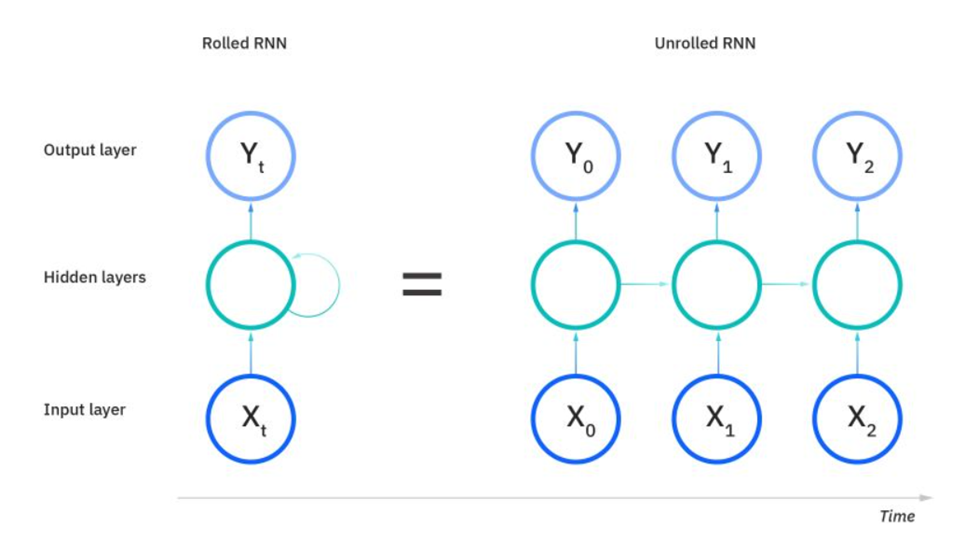
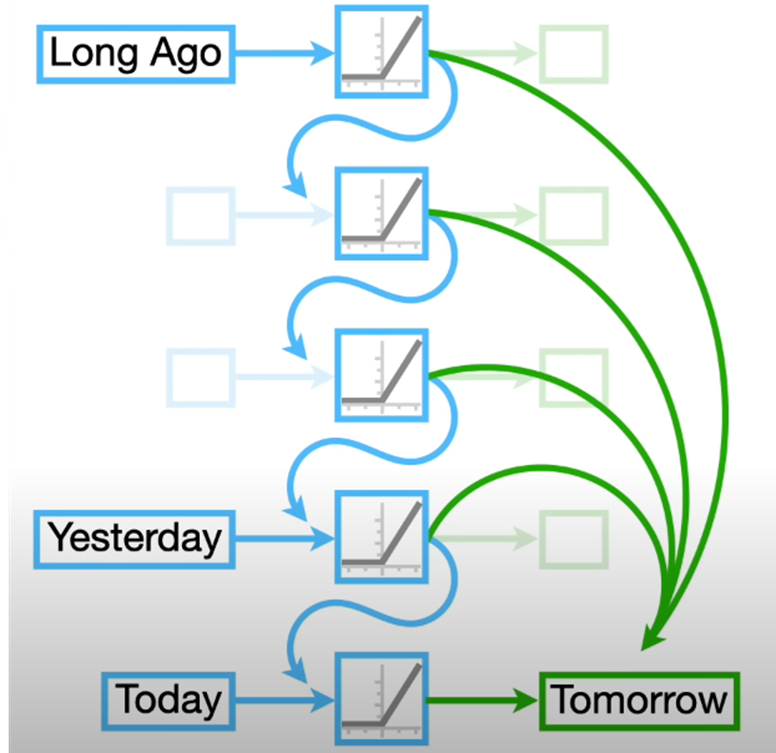
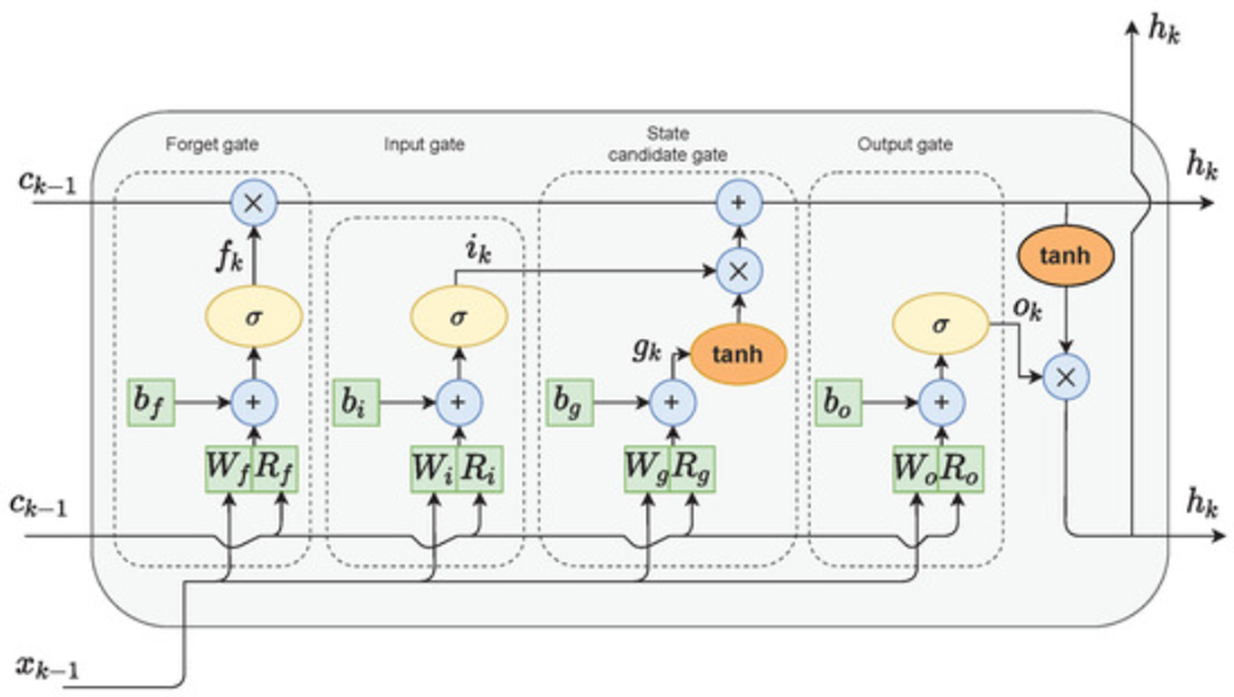

In [265]:
from numpy import genfromtxt
import keras

### Get users

In [266]:
users = []
user_dirs = glob(f'./ParametrizedData/*/', recursive=False)

for i, dir in enumerate(user_dirs):
    dir = os.path.dirname(dir)
    user = os.path.basename(dir)
    users.append(user)

print(users[:20])

['1006', '102', '104', '1049', '1051', '1065', '107', '1084', '1085', '1092', '1094', '1096', '1097', '110', '1107', '111', '1110', '1124', '1132', '1152']


### Define DataGenerator class

In [267]:
from keras.utils import Sequence, to_categorical

In [268]:
class DataGenerator(Sequence):
    def __init__(self, list_files, list_labels, batch_size, dim, n_classes, shuffle):
        self.dim = dim
        self.batch_size = batch_size
        self.list_files = list_files
        self.list_labels = list_labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_files_temp = [self.list_files[k] for k in indexes]
        X, y = self.__data_generation(list_files_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_files_temp):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        for i, file in enumerate(list_files_temp):
            X[i,] = genfromtxt(file, delimiter=',').T
            user = get_user_id(file)
            y[i] = self.list_labels[user]

        return X, to_categorical(y, num_classes=self.n_classes)

### Create model

In [269]:
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import random

In [270]:
def create_lstm_model(input_shape, n_classes):
    model = keras.Sequential()
    
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### Get train and validation data sets

In [271]:
from sklearn.model_selection import train_test_split

In [331]:
n_classes = 1000
train_classes = 800

usable_users = random.sample(users, n_classes)
train_users = usable_users[:train_classes]
bmodel_users = usable_users[train_classes:] 

train_files, valid_files = [], []
labels = {}

for i, user in tqdm(enumerate(train_users), total=len(train_users)):
    labels[user] = i
    
    user_files = glob(f'./ParametrizedData/{user}/*.csv', recursive=False)

    u_train_files, u_valid_files = train_test_split(user_files, test_size=0.1)

    train_files.extend(u_train_files)
    valid_files.extend(u_valid_files)

print(f'train files: {len(train_files)}')
print(f'validation files: {len(valid_files)}')
print(f'user count: {len(labels)}')

  0%|          | 0/800 [00:00<?, ?it/s]

train files: 352689
validation files: 39593
user count: 800


In [332]:
input_shape = (87, 60)

train_generator = DataGenerator(train_files, labels, 64, input_shape, train_classes, True)
validation_generator = DataGenerator(valid_files, labels, 64, input_shape, train_classes, True)

### Train model

In [333]:
model = create_lstm_model(input_shape, train_classes)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               96768     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               16512     
                                                                 
 dropout_30 (Dropout)        (None, 128)             

In [336]:
history = model.fit(x=train_generator, 
          validation_data=validation_generator,
          use_multiprocessing=False,
          epochs=10,
          verbose=1)

Epoch 1/10
5510/5510 [==============================] - 2135s 387ms/step - loss: 0.0042 - accuracy: 0.4025 - val_loss: 0.0029 - val_accuracy: 0.6069
Epoch 2/10
5510/5510 [==============================] - 2496s 453ms/step - loss: 0.0041 - accuracy: 0.4159 - val_loss: 0.0028 - val_accuracy: 0.6322
Epoch 3/10
5510/5510 [==============================] - 2525s 458ms/step - loss: 0.0040 - accuracy: 0.4284 - val_loss: 0.0027 - val_accuracy: 0.6508
Epoch 4/10
5510/5510 [==============================] - 2420s 439ms/step - loss: 0.0040 - accuracy: 0.4404 - val_loss: 0.0025 - val_accuracy: 0.6769
Epoch 5/10
5510/5510 [==============================] - 2084s 378ms/step - loss: 0.0039 - accuracy: 0.4512 - val_loss: 0.0025 - val_accuracy: 0.6840
Epoch 6/10
5510/5510 [==============================] - 2089s 379ms/step - loss: 0.0038 - accuracy: 0.4608 - val_loss: 0.0026 - val_accuracy: 0.6694
Epoch 7/10
5510/5510 [==============================] - 2090s 379ms/step - loss: 0.0038 - accuracy: 0.4708

### Vizualize model

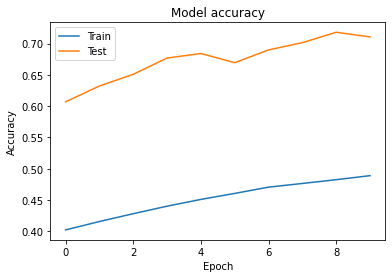

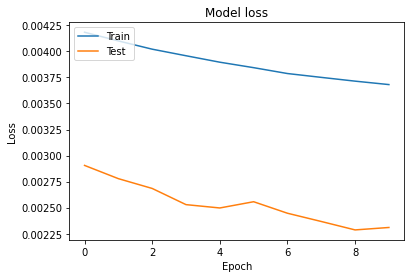

In [337]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

## Create biometric model

In [338]:
from sklearn.metrics.pairwise import cosine_similarity

In [339]:
def get_score(emb_1, emb_2):
  emb_1 = np.array(emb_1)
  emb_2 = np.array(emb_2)
  score = cosine_similarity(emb_1.reshape(1, -1), emb_2.reshape(1, -1))[0][0]
  return score

### Calculate embedings

In [340]:
from keras import backend as K

def get_inner_layer_output(x, n):
    get_nth_layer_output = K.function([model.layers[0].input],
                                        [model.layers[n].output])
    layer_output = get_nth_layer_output([x])[0]
    return layer_output

In [341]:
from tqdm.notebook import tqdm

embedings = {}

for user in tqdm(bmodel_users):
    embedings[user] = []

    user_files = glob(f'./ParametrizedData/{user}/*.csv', recursive=False)

    for file in user_files:
        x = genfromtxt(file, delimiter=',').T
        x = np.expand_dims(x, axis=0)
        emb = get_inner_layer_output(x, -3)
        emb = np.array(emb)
        embedings[user].append(emb)

  0%|          | 0/200 [00:00<?, ?it/s]

### Calculate enrollment data and genuine tests

In [342]:
TP = []
enrolls = {}

enroll_percent = 0.4

for user in tqdm(bmodel_users):
    count = len(embedings[user])
    enroll_count = int(count * enroll_percent)

    embs = []
    for i in range(enroll_count):
        embs.append(embedings[user][i])

    enroll_emb = np.array(embs).mean(0)
    enrolls[user] = enroll_emb
    
    for i in range(enroll_count, count):
        test_emb = embedings[user][i]
        score = get_score(enroll_emb, test_emb)
        TP.append(score)


  0%|          | 0/200 [00:00<?, ?it/s]

### Calculate impostor tests

In [343]:
TN = []

for user in tqdm(bmodel_users):
    tn_scores = []

    for test_user in bmodel_users:
        if test_user == user: continue

        for test_emb in embedings[test_user]:
            enroll_emb = enrolls[user]
            score = get_score(enroll_emb, test_emb)
            TN.append(score)

  0%|          | 0/200 [00:00<?, ?it/s]

### Results

In [344]:
import matplotlib
import math

In [345]:
def draw_far_frr():
    legend_score = ['score True Negative', 'score True Positive']
    legend_f = ['false acceptance rate', 'false rejection rate']
    ranges = [0, 1]

    plt.figure(figsize=(25, 10))
    model_range = [0, 1]

    plt.subplot(2, 1, 1)
    plt.title(f"LSTM Model")

    n_TN, bins, _ = plt.hist(TN, bins=200, range=model_range, alpha=0.5)
    n_TP, bins, _ = plt.hist(TP, bins=200, range=model_range, alpha=0.5)

    plt.grid()
    plt.xlim(model_range)
    plt.legend(legend_score, loc='upper right')
    plt.xlabel('log likelihood')
    plt.yscale('log')

    far = np.cumsum(n_TN)
    far /= far[-1]
    far = 1 - far

    frr = np.cumsum(n_TP)
    frr /= frr[-1]

    far_frr = (far, frr)

    plt.subplot(2, 1, 2)
    plt.plot(bins[1:], far_frr[0])
    plt.plot(bins[1:], far_frr[1])
    plt.legend(legend_f, loc='lower left')
    plt.xlabel('threshold')
    plt.ylabel('probability')
    plt.grid()
    plt.show()

    return far_frr

In [382]:
def draw_det(far_frr):
    plt.figure(figsize=(10, 10))

    axis_min = 0
    fig,ax = plt.subplots(figsize=(10, 10))

    plt.yscale('log')
    plt.xscale('log')

    ticks_to_use = [8, 10, 50, 100]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    legend_det = [dir]

    x = range(100)
    plt.plot(x, x, '--', label='f(x) = x')

    (far, frr) = far_frr
    plt.plot(far*100, frr*100, '-', label='MLP')

    p = 10
    plt.plot(p, p, 'ro', label='EER')
    plt.annotate(f'{p}', (p - 0.2, p + 0.24))

    plt.axis([8,100,8,100])
    plt.grid()
    plt.legend(loc='upper right')
    plt.xlabel('false acceptance rate (%)')
    plt.ylabel('false rejection rate (%)')
    plt.show()

<Figure size 720x720 with 0 Axes>

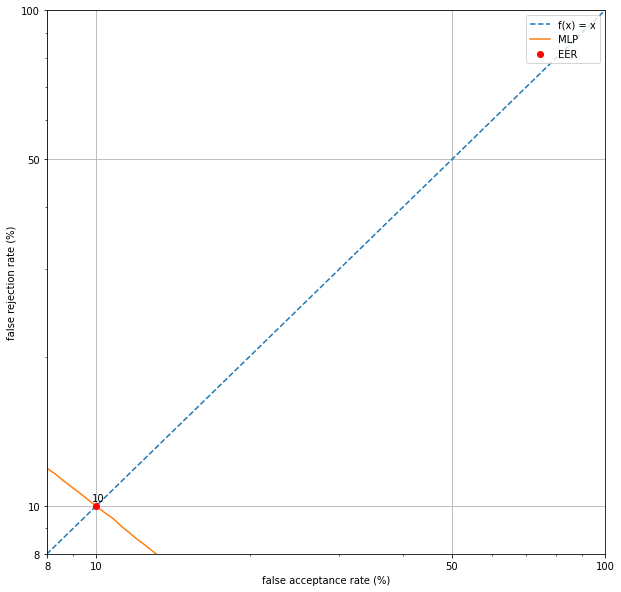

In [383]:
#far_frr = draw_far_frr()
draw_det(far_frr)